In [1]:
import pandas as pd
import numpy as np
import networkx as nx
#import geopandas
#from shapely.geometry import Point
import matplotlib.pyplot as plt
from sodapy import Socrata
from datetime import datetime

In [2]:
def getData(limit):
    client = Socrata("data.cityofnewyork.us", None)
    results = client.get("2yzn-sicd", limit = limit)
    results_df = pd.DataFrame.from_records(results)
    return results_df

In [3]:
taxi = getData(2000)

## Preprocessing: deleting zero columns and useless columns

In [4]:
def parseDate(dateStr):
    return datetime.strptime(dateStr.split(".")[0], "%Y-%m-%dT%H:%M:%S")

In [5]:
def preprocessDataRow(row):
    pickupDatetime = parseDate(row["pickup_datetime"])
    row["pickup_weekday"] = pickupDatetime.weekday()
    row["pickup_time"] = pickupDatetime.time()
    
    dropoffDatetime = parseDate(row["dropoff_datetime"])
    row["dropoff_weekday"] = dropoffDatetime.weekday()
    row["dropoff_time"] = dropoffDatetime.time()
    return row

In [6]:
taxi = taxi.apply(preprocessDataRow, axis = 1)

taxi["dropoff_latitude"] = taxi["dropoff_latitude"].astype('float64')
taxi["dropoff_longitude"] = taxi["dropoff_longitude"].astype('float64')
taxi["pickup_latitude"] = taxi["pickup_latitude"].astype('float64')
taxi["pickup_longitude"] = taxi["pickup_longitude"].astype('float64')
taxi["fare_amount"] = taxi["fare_amount"].astype('float64')
print(len(taxi))

maxLatitude = 43
minLatitude = 38
maxLongitude = -72
minLongitude = -76

taxi.drop(taxi[
    (taxi.dropoff_latitude > maxLatitude) | 
    (taxi.pickup_latitude > maxLatitude) |
    (taxi.dropoff_latitude < minLatitude) | 
    (taxi.pickup_latitude < minLatitude) |
    (taxi.dropoff_longitude > maxLongitude) | 
    (taxi.pickup_longitude > maxLongitude) |
    (taxi.dropoff_longitude < minLongitude) | 
    (taxi.pickup_longitude < minLongitude)
].index, inplace = True)

taxi_filtered = taxi

coordinates = taxi_filtered[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']]
print(len(coordinates))

2000
1940


### build tuples of dropoff and pickup

In [7]:
lol=coordinates
pickup=lol.drop(["dropoff_longitude","dropoff_latitude"],axis=1)
dropoff=lol.drop(["pickup_longitude","pickup_latitude"],axis=1)

In [8]:
tuples=pickup.itertuples(index=False)
pickup_tuples=np.array(list(tuples))
tuples=dropoff.itertuples(index=False)
dropoff_tuples=np.array(list(tuples))

In [9]:
pickup_tuples=pickup_tuples.astype('float64')
dropoff_tuples=dropoff_tuples.astype('float64')

In [10]:
print(len(np.unique(pickup_tuples,axis=0)))
print(len(pickup_tuples))
print(len(np.unique(pickup_tuples,axis=0)))
print(len(dropoff_tuples))

1940
1940
1940
1940


In [11]:
#round coordinates
pickup_tuples=pickup_tuples.round(2)
dropoff_tuples=dropoff_tuples.round(2)

In [12]:
print(len(np.unique(pickup_tuples,axis=0)))
print(len(pickup_tuples))
print(len(np.unique(pickup_tuples,axis=0)))
print(len(dropoff_tuples))

109
1940
109
1940


In [13]:
#invert coordinates so it fits with x and y axis
pickup_tuples_invert=[]
dropoff_tuples_invert=[]

for i in range(len(pickup_tuples)):
    #print(pickup_tuples[i])
    pickup_tuples_invert.append([pickup_tuples[i,1],pickup_tuples[i,0]])
pickup_tuples=np.array(pickup_tuples_invert)

for i in range(len(dropoff_tuples)):
    #print(dropoff_tuples[i])
    dropoff_tuples_invert.append([dropoff_tuples[i,1],dropoff_tuples[i,0]])
dropoff_tuples=np.array(dropoff_tuples_invert)

In [14]:
#create a list of tuples
pickup_list=[]
for i in range(len(pickup_tuples)):
    a=(pickup_tuples[i,0],pickup_tuples[i,1])
    pickup_list.append(a)
dropoff_list=[]
for i in range(len(dropoff_tuples)):
    a=(dropoff_tuples[i,0],dropoff_tuples[i,1])
    dropoff_list.append(a)

# safe coordinates as tuples in table
taxi_filtered['drop_off'] = dropoff_list
taxi_filtered['pick_up'] = pickup_list
del taxi_filtered['dropoff_latitude']
del taxi_filtered['dropoff_longitude']
del taxi_filtered['pickup_latitude']
del taxi_filtered['pickup_longitude']
taxi_filtered


,dropoff_datetime,extra,fare_amount,mta_tax,passenger_count,payment_type,pickup_datetime,rate_code,store_and_fwd_flag,tip_amount,tolls_amount,total_amount,trip_distance,vendor_id,pickup_weekday,pickup_time,dropoff_weekday,dropoff_time,drop_off,pick_up
0,2015-02-13T00:15:36.000,0.5,5.0,0.5,5,2,2015-02-13T00:11:28.000,1,N,0,0,6.3,0.6,2,4,00:11:28,4,00:15:36,"(-73.98, 40.75)","(-73.99, 40.75)"
1,2015-06-13T01:56:19.000,0.5,19.0,0.5,1,1,2015-06-13T01:33:30.000,1,N,0,0,20.3,5.2,1,5,01:33:30,5,01:56:19,"(-73.98, 40.7)","(-73.99, 40.76)"
2,2015-01-06T09:04:52.000,0,22.5,0.5,5,2,2015-01-06T08:28:23.000,1,N,0,0,23.3,3.7,2,1,08:28:23,1,09:04:52,"(-73.95, 40.77)","(-73.98, 40.74)"
3,2015-02-18T18:33:49.000,1,7.0,0.5,1,1,2015-02-18T18:26:19.000,1,N,1.76,0,10.56,1.34,2,2,18:26:19,2,18:33:49,"(-73.99, 40.72)","(-73.98, 40.74)"
4,2015-05-17T23:23:45.000,0.5,14.0,0.5,1,2,2015-05-17T23:11:06.000,1,N,0,0,15.3,3.9,1,6,23:11:06,6,23:23:45,"(-73.96, 40.8)","(-73.98, 40.75)"
5,2015-03-31T15:21:46.000,0,6.0,0.5,6,2,2015-03-31T15:15:16.000,1,N,0,0,6.8,1.07,2,1,15:15:16,1,15:21:46,"(-74.0, 40.75)","(-73.99, 40.75)"
6,2015-03-10T16:00:47.000,0,5.5,0.5,3,1,2015-03-10T15:54:31.000,1,N,0.5,0,6.8,0.71,2,1,15:54:31,1,16:00:47,"(-73.99, 40.75)","(-73.99, 40.74)"
7,2015-01-30T20:30:01.000,0.5,8.0,0.5,1,1,2015-01-30T20:21:56.000,1,N,1,0,10.3,1.45,2,4,20:21:56,4,20:30:01,"(-73.96, 40.77)","(-73.97, 40.76)"
8,2015-01-20T02:52:30.000,0.5,15.0,0.5,2,1,2015-01-20T02:40:15.000,1,N,3.25,0,19.55,4.7,1,1,02:40:15,1,02:52:30,"(-73.94, 40.8)","(-73.99, 40.76)"
9,2015-06-05T09:28:34.000,0,26.5,0.5,1,1,2015-06-05T08:55:33.000,1,N,5.46,0,32.76,5.97,2,4,08:55:33,4,09:28:34,"(-73.97, 40.76)","(-74.01, 40.71)"


In [15]:
#create edges by linking dropoffs to pickups
edges=[]
for i in range(len(pickup_list)):
    edges.append((pickup_list[i],dropoff_list[i]))

In [16]:
# delete identical edges as well as grab the count of edges for coloring
edges,index=np.unique(np.array(edges),axis=0,return_counts=True)

In [17]:
#grab the maximum number of the same edge to make classes of edge counts
count=max(index)
print(a)

(-73.98, 40.77)


In [18]:
index[index<=(count/2)]=0
index[index>(count/2)]=1
#index=index[index>=(a/2)]

In [ ]:
#build color array
colors=[]
for i in range(len(index)):
    if index[i]==1:
        colors.append("r")
    else:
        colors.append("b")

## Graph of whole area

In [ ]:
#build graph
g=nx.Graph()
#g=nx.DiGraph()

In [ ]:
#build a list of nodes from pickup and arrival and make it distinct
node_list=[]
for i in range(len(pickup_list)):
    node_list.append(pickup_list[i])
for i in range(len(dropoff_list)):
    node_list.append(dropoff_list[i])
print(len(node_list))
node_list=list(set(node_list))
print(len(node_list))
g.add_nodes_from(node_list)

3880
185


In [ ]:
# transform edge array into tuple form for adding it to graph
edge_tuples=[]
for i in range(len(edges)):
    edge_tuples.append(((edges[i,0,0],edges[i,0,1]),(edges[i,1,0],edges[i,1,1])))
g.add_edges_from(edge_tuples)

In [ ]:
#build the position array by mapping the name of the tuple to the coordinates
position = {}
for i in range(len(node_list)):
    position.update({node_list[i]:node_list[i]})

In [ ]:
nx.average_clustering(g)

0.26769039855328225

In [ ]:
#set the size of the plot
plt.rcParams["figure.figsize"] = (20,10)

/home/johny/study/network-analysis/project/venv/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


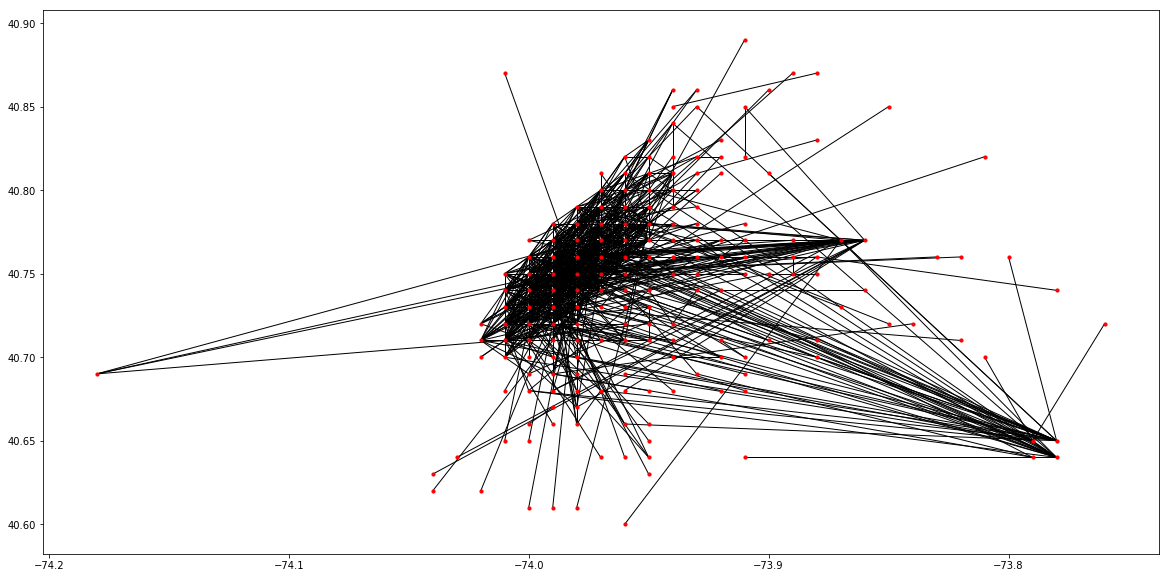

In [ ]:
nx.draw_networkx(g, node_size = 10,with_labels=False,pos=position)

## Graph of only the center region

In [ ]:
g_center=nx.DiGraph()

In [ ]:
center_nodes=[]
for i in node_list:    
    if i[0]<-74.1 or i[0]>-73.9 or i[1]<40.65 or i[0]>40.85:
        pass
    else:
        center_nodes.append(i)   
g_center.add_nodes_from(center_nodes)

In [ ]:
center_edges=[]
for i in edge_tuples:
    if i[0][0]<-74.1 or i[0][0]>-73.9 or i[0][1]<40.65 or i[0][1]>40.85:
        pass
    else:
        if i[1][0]<-74.1 or i[1][0]>-73.9 or i[1][1]<40.65 or i[1][1]>40.85:
            pass
        else:
            center_edges.append(i)
g_center.add_edges_from(center_edges)
print(len(center_edges))

948


In [ ]:
center_position = {}
a=list(g_center.nodes)
for i in range(len(a)):
    center_position.update({a[i]:a[i]})
print(len(center_position))

142


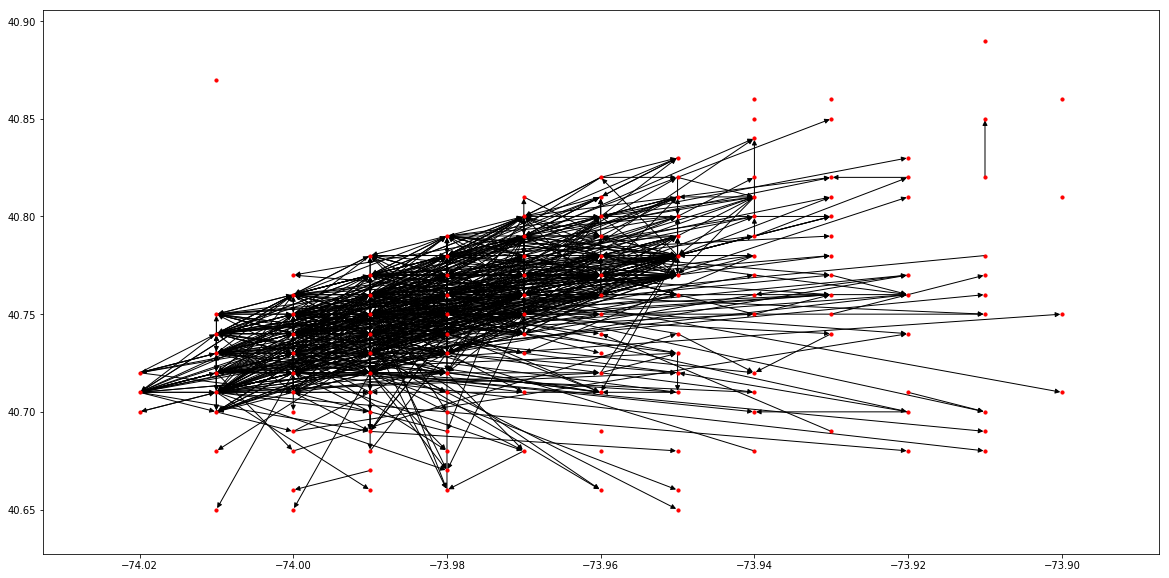

In [ ]:
nx.draw_networkx(g_center, node_size = 10,with_labels=False,pos=center_position)

## experimental stuff

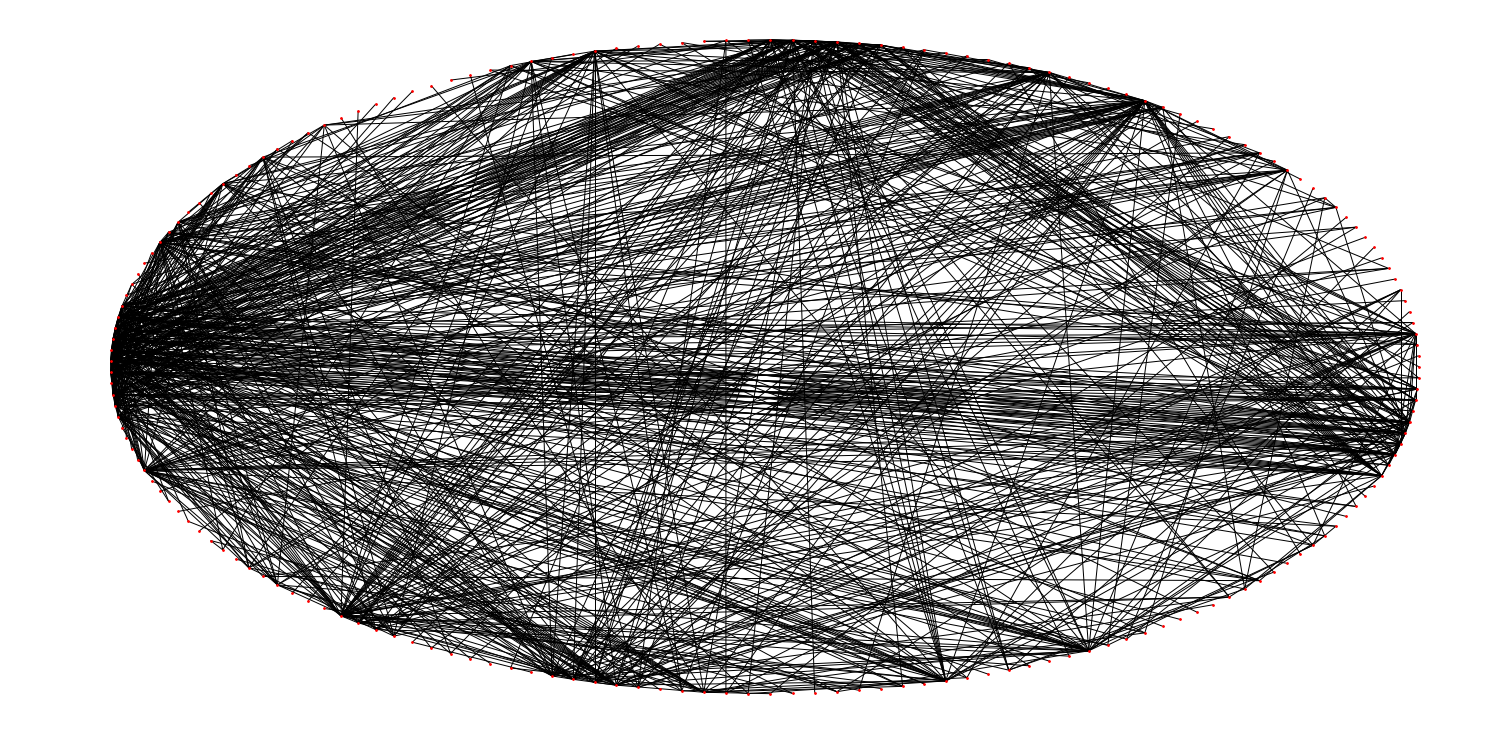

In [ ]:
nx.draw_circular(g,node_size=3)

In [ ]:
from networkx.algorithms import community

In [ ]:
# this works only on undirected graphs

c = list(community.greedy_modularity_communities(g))
# number of identified communitiess
print(len(c))
#nx.draw_networkx_nodes(g,position, node_size=4,with_labels=False) #draw all nodes

10


In [ ]:
taxi_filtered

,dropoff_datetime,extra,fare_amount,mta_tax,passenger_count,payment_type,pickup_datetime,rate_code,store_and_fwd_flag,tip_amount,tolls_amount,total_amount,trip_distance,vendor_id,pickup_weekday,pickup_time,dropoff_weekday,dropoff_time,drop_off,pick_up
0,2015-02-13T00:15:36.000,0.5,5.0,0.5,5,2,2015-02-13T00:11:28.000,1,N,0,0,6.3,0.6,2,4,00:11:28,4,00:15:36,"(-73.98, 40.75)","(-73.99, 40.75)"
1,2015-06-13T01:56:19.000,0.5,19.0,0.5,1,1,2015-06-13T01:33:30.000,1,N,0,0,20.3,5.2,1,5,01:33:30,5,01:56:19,"(-73.98, 40.7)","(-73.99, 40.76)"
2,2015-01-06T09:04:52.000,0,22.5,0.5,5,2,2015-01-06T08:28:23.000,1,N,0,0,23.3,3.7,2,1,08:28:23,1,09:04:52,"(-73.95, 40.77)","(-73.98, 40.74)"
3,2015-02-18T18:33:49.000,1,7.0,0.5,1,1,2015-02-18T18:26:19.000,1,N,1.76,0,10.56,1.34,2,2,18:26:19,2,18:33:49,"(-73.99, 40.72)","(-73.98, 40.74)"
4,2015-05-17T23:23:45.000,0.5,14.0,0.5,1,2,2015-05-17T23:11:06.000,1,N,0,0,15.3,3.9,1,6,23:11:06,6,23:23:45,"(-73.96, 40.8)","(-73.98, 40.75)"
5,2015-03-31T15:21:46.000,0,6.0,0.5,6,2,2015-03-31T15:15:16.000,1,N,0,0,6.8,1.07,2,1,15:15:16,1,15:21:46,"(-74.0, 40.75)","(-73.99, 40.75)"
6,2015-03-10T16:00:47.000,0,5.5,0.5,3,1,2015-03-10T15:54:31.000,1,N,0.5,0,6.8,0.71,2,1,15:54:31,1,16:00:47,"(-73.99, 40.75)","(-73.99, 40.74)"
7,2015-01-30T20:30:01.000,0.5,8.0,0.5,1,1,2015-01-30T20:21:56.000,1,N,1,0,10.3,1.45,2,4,20:21:56,4,20:30:01,"(-73.96, 40.77)","(-73.97, 40.76)"
8,2015-01-20T02:52:30.000,0.5,15.0,0.5,2,1,2015-01-20T02:40:15.000,1,N,3.25,0,19.55,4.7,1,1,02:40:15,1,02:52:30,"(-73.94, 40.8)","(-73.99, 40.76)"
9,2015-06-05T09:28:34.000,0,26.5,0.5,1,1,2015-06-05T08:55:33.000,1,N,5.46,0,32.76,5.97,2,4,08:55:33,4,09:28:34,"(-73.97, 40.76)","(-74.01, 40.71)"


In [ ]:
# com = all nodess in community 

com_edges = list()
fares = list()
start_dates = list()
end_dates = list()
start_dates_weekdays=list()

for i in range(len(c)):
    com = [tuple(x) for x in c[i]]

    com_edges_i = list()
    fares_i = list()
    start_dates_i = list()
    end_dates_i = list()
    start_dates_weekday_i=list()
    
    # get all edges(trips) only within nodes in community 1 and price and time of trips
    # (edges with end and start point in community 1)
    for e in g.edges:
        if tuple(e[0]) in set(com) and tuple(e[1]) in set(com):
            com_edges_i.append(e)
            fares_i += list(map(lambda x: float(x),(taxi_filtered.loc[ list(taxi_filtered[  (taxi_filtered['pick_up']==e[0]) & (taxi_filtered['drop_off']==e[1]) ].index), 'fare_amount' ])))
            start_dates_i += list((taxi_filtered.loc[ list(taxi_filtered[  (taxi_filtered['pick_up']==e[0]) & (taxi_filtered['drop_off']==e[1]) ].index), 'pickup_time' ]))
            end_dates_i += list((taxi_filtered.loc[ list(taxi_filtered[  (taxi_filtered['pick_up']==e[0]) & (taxi_filtered['drop_off']==e[1]) ].index), 'dropoff_time' ]))
            start_dates_weekday_i += list((taxi_filtered.loc[ list(taxi_filtered[  (taxi_filtered['pick_up']==e[0]) & (taxi_filtered['drop_off']==e[1]) ].index), 'pickup_weekday' ]))
    
    com_edges.append(com_edges_i)
    fares.append(fares_i)
    start_dates.append(start_dates_i)
    end_dates.append(end_dates_i)
    start_dates_weekdays.append(start_dates_weekday_i)
    # draw all nodes of community 1 and all edges within those nodes
    nx.draw_networkx(g,position,nodelist=com,edgelist=com_edges_i,node_color='c',node_size=8,with_labels=False, width=0.5)

In [ ]:
fares_new=[]

for i in fares:
    fares_local=[]
    for j in i:
        if j ==300:
            print("gefunden")
        else:
            fares_local.append(j)
    fares_new.append(fares_local)

In [ ]:
# draw all nodes of community 1 and all edges within those nodes
print(fares)
print(start_dates)
print(end_dates)

In [ ]:
plt.rcParams["figure.figsize"] = (10,5)
for i in range(len(start_dates_weekdays)):
    print("Community: "+str(i))
    plt.ylabel('Amounts of Rides')
    plt.xlabel('Weekdays')
    plt.hist(start_dates_weekdays[i], bins=7)
    plt.show()

In [ ]:
plt.clf()

In [ ]:
for i in range(len(start_dates)):
    print("Community: "+str(i))
    b=[]
    for j in start_dates[i]:
        #print(j)
        b.append(j.hour)
    plt.hist(b, bins=24)
    plt.ylabel('Amounts of Rides')
    plt.xlabel('Hours')
    plt.show()

In [ ]:
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)
ax.set_xlabel('Community')
ax.set_ylabel('Fare')

bp = ax.boxplot(fares, patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)